In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import olympus
from olympus import __home__
from olympus.campaigns import Campaign, ParameterSpace
from olympus.datasets import Dataset
from olympus.emulators import Emulator
from olympus.planners import Planner
from olympus.models import BayesNeuralNet

from olympus.objects import (
    ParameterContinuous,ParameterDiscrete,ParameterOrdinal,ParameterCategorical
)


In [2]:
# make continuous parameter ordinal target dataset

df = pd.read_csv(
    f'{__home__}/datasets/dataset_mock_ordinal_emulator/data.csv',
    names=['p3ht_content', 'd1_content', 'd2_content', 'd6_content', 'd8_content', 'conductivity']
)
print(df.shape)
df.head()

(178, 6)


,p3ht_content,d1_content,d2_content,d6_content,d8_content,conductivity
0,75.0,0.0,25.0,0.0,0.0,not_conductive
1,30.0,0.0,70.0,0.0,0.0,not_conductive
2,45.0,0.0,55.0,0.0,0.0,not_conductive
3,90.0,0.0,0.0,10.0,0.0,not_conductive
4,95.0,0.0,0.0,0.0,5.0,not_conductive


/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='conductivity', ylabel='Density'>

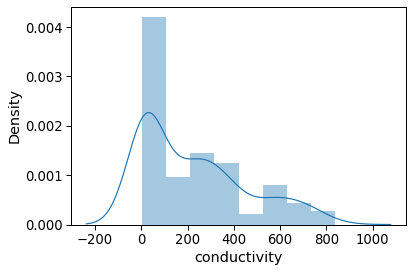

In [8]:
sns.distplot(df['conductivity'])

In [9]:
ordinal_conducts = []
cont_conducts = list(df['conductivity'])
for cont in cont_conducts:
    if 0.<=cont<200.:
        ordinal_conducts.append("not_conductive")
    elif 200.<cont<=600.:
        ordinal_conducts.append("somewhat_conductive")
    else:
        ordinal_conducts.append("very_conductive")

In [11]:
df['conductivity']=ordinal_conducts

In [12]:
df.to_csv(f'{__home__}/datasets/dataset_mock_ordinal_emulator/data.csv', index=False)

In [15]:
dataset = Dataset(kind='mock_ordinal_emulator')
print(dataset.param_space)
print(dataset.value_space)

Continuous (name='p3ht_content', low=15.0, high=96.27, is_periodic=False)
Continuous (name='d1_content', low=0.0, high=60.0, is_periodic=False)
Continuous (name='d2_content', low=0.0, high=70.0, is_periodic=False)
Continuous (name='d6_content', low=0.0, high=85.0, is_periodic=False)
Continuous (name='d8_content', low=0.0, high=75.0, is_periodic=False)
Ordinal (name='conductivity', num_opts=3, options=['not_conductive', 'somewhat_conductive', 'very_conductive'], order=[0 1 2])


In [16]:
# build new emulator

params = {
    'task': 'classification',
    'batch_size': 50,
    'hidden_act': 'leaky_relu',
    'hidden_depth': 4,
    'hidden_nodes': 42,
    'learning_rate': 0.001,
    'reg': 0.01,
    'out_act': 'sigmoid',
}

model = BayesNeuralNet(**params)

In [17]:
print(model)


--> batch_size:    50
--> es_patience:   100
--> hidden_act:    leaky_relu
--> hidden_depth:  4
--> hidden_nodes:  42
--> kind:          BayesNeuralNet
--> learning_rate: 0.001
--> max_epochs:    100000
--> out_act:       sigmoid
--> pred_int:      100
--> reg:           0.01
--> scope:         model
--> task:          classification


In [18]:
emulator = Emulator(
    dataset=dataset,
    model=model,
    feature_transform='standardize',
    target_transform='identity',
)

In [19]:
scores = emulator.cross_validate()

[INFO] >>> Training model on fold #0...


/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)
/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)


[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.429          0.503         -1.128          0.507 *
[INFO]             100          0.143          0.312          0.269          0.200 *
[INFO]             200          0.236          0.291          0.380          0.177 *
[INFO]             300          0.242          0.288          0.465          0.162 *
[INFO]             400          0.249          0.288          0.442          0.169
[INFO]             500          0.235          0.290          0.497          0.154 *
[INFO]             600          0.305          0.271          0.419          0.170
[INFO]             700          0.279          0.271          0.510          0.154
[INFO]             800          0.319          0.262          0.444          

[INFO]            8600          0.665          0.017          0.028          0.272
[INFO]            8700          0.665          0.013          0.030          0.280
[INFO]            8800          0.665          0.014          0.031          0.273
[INFO]            8900          0.665          0.014          0.116          0.262
[INFO]            9000          0.656          0.036          0.062          0.260
[INFO]            9100          0.665          0.014          0.006          0.283
[INFO]            9200          0.666          0.011          0.025          0.278
[INFO]            9300          0.665          0.013          0.065          0.270
[INFO]            9400          0.661          0.027          0.010          0.279
[INFO]            9500          0.666          0.010          0.128          0.260
[INFO]            9600          0.665          0.016         -0.133          0.280
[INFO]            9700          0.666          0.006          0.024          0.287
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)
/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)


[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.396          0.496         -0.492          0.494 *
[INFO]             100          0.293          0.235          0.261          0.238 *
[INFO]             200          0.440          0.195          0.375          0.220 *
[INFO]             300          0.445          0.197          0.328          0.223
[INFO]             400          0.461          0.187          0.377          0.214 *
[INFO]             500          0.449          0.190          0.376          0.218
[INFO]             600          0.459          0.188          0.364          0.219
[INFO]             700          0.481          0.179          0.385          0.219
[INFO]             800          0.469          0.181          0.358          0.

[INFO]            8600          0.666          0.005          0.534          0.291
[INFO]            8700          0.641          0.080          0.280          0.254
[INFO]            8800          0.664          0.018          0.516          0.296
[INFO]            8900          0.666          0.007          0.536          0.290
[INFO]            9000          0.667          0.002          0.176          0.297
[INFO]            9100          0.667          0.002          0.532          0.293
[INFO]            9200          0.667          0.002          0.494          0.299
[INFO]            9300          0.667          0.002          0.168          0.298
[INFO]            9400          0.667          0.002          0.521          0.295
[INFO]            9500          0.666          0.007          0.540          0.289
[INFO]            9600          0.667          0.004          0.102          0.320
[INFO]            9700          0.667          0.004          0.200          0.291
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)
/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)


[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.461          0.505         -2.052          0.504 *
[INFO]             100          0.277          0.239          0.146          0.209 *
[INFO]             200          0.380          0.213          0.325          0.196 *
[INFO]             300          0.439          0.197          0.443          0.185 *
[INFO]             400          0.424          0.203          0.429          0.198
[INFO]             500          0.452          0.193          0.427          0.188
[INFO]             600          0.453          0.192          0.404          0.196
[INFO]             700          0.430          0.198          0.431          0.207
[INFO]             800          0.463          0.189          0.339          0.

[INFO]            8600          0.628          0.088          0.222          0.233
[INFO]            8700          0.620          0.094          0.305          0.210
[INFO]            8800          0.612          0.097          0.128          0.237
[INFO]            8900          0.638          0.083          0.026          0.242
[INFO]            9000          0.637          0.083          0.115          0.238
[INFO]            9100          0.638          0.082          0.170          0.240
[INFO]            9200          0.637          0.083          0.180          0.236
[INFO]            9300          0.638          0.082          0.139          0.235
[INFO]            9400          0.621          0.093          0.259          0.232
[INFO]            9500          0.742          0.212          0.514          0.227
[INFO]            9600          0.790          0.184          0.102          0.224
[INFO]            9700          0.795          0.182          0.528          0.217
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)
/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)


[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.130          0.499         -0.886          0.498 *
[INFO]             100          0.138          0.262          0.236          0.225 *
[INFO]             200          0.321          0.239          0.263          0.219 *
[INFO]             300          0.370          0.232          0.213          0.227
[INFO]             400          0.372          0.230          0.201          0.228
[INFO]             500          0.392          0.221          0.185          0.232
[INFO]             600          0.408          0.221          0.140          0.243
[INFO]             700          0.403          0.218          0.135          0.249
[INFO]             800          0.424          0.212          0.082          0.25

[INFO]            8600          0.571          0.095         -0.036          0.318
[INFO]            8700          0.575          0.090         -0.011          0.317
[INFO]            8800          0.579          0.087         -0.038          0.317
[INFO]            8900          0.583          0.083         -0.034          0.320
[INFO]            9000          0.582          0.084         -0.032          0.321
[INFO]            9100          0.582          0.077         -0.029          0.319
[INFO]            9200          0.591          0.077         -0.031          0.319
[INFO]            9300          0.586          0.079         -0.132          0.340
[INFO]            9400          0.566          0.108          0.243          0.331
[INFO]            9500          0.586          0.073         -0.065          0.329
[INFO]            9600          0.584          0.078         -0.051          0.326
[INFO]            9700          0.582          0.080         -0.063          0.328
[INF

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)
/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)


[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -2.217          0.523         -0.210          0.519 *
[INFO]             100          0.259          0.191          0.209          0.302 *
[INFO]             200          0.398          0.159          0.210          0.302
[INFO]             300          0.428          0.152          0.169          0.313
[INFO]             400          0.450          0.144          0.179          0.312
[INFO]             500          0.400          0.165          0.213          0.301 *
[INFO]             600          0.415          0.157          0.191          0.308
[INFO]             700          0.382          0.169          0.235          0.294 *
[INFO]             800          0.431          0.150          0.215          0.

[INFO]            8600          0.661          0.034         -0.014          0.365
[INFO]            8700          0.663          0.028          0.038          0.352
[INFO]            8800          0.664          0.023          0.106          0.334
[INFO]            8900          0.664          0.022          0.043          0.352
[INFO]            9000          0.660          0.033          0.003          0.362
[INFO]            9100          0.831          0.086         -0.003          0.363
[INFO]            9200          0.995          0.033          0.111          0.335
[INFO]            9300          0.650          0.054          0.023          0.358
[INFO]            9400          0.664          0.023          0.056          0.349
[INFO]            9500          0.663          0.029          0.036          0.353
[INFO]            9600          0.998          0.021          0.042          0.353
[INFO]            9700          0.998          0.019         -0.002          0.363
[INF

AttributeError: Object has no attribute metrics_names

In [8]:
emulator.dataset.target_names

['conductivity']

In [9]:
print(emulator.value_space[0].num_opts)

AttributeError: Object has no attribute num_opts

In [10]:
'acc'.upper()

'ACC'